## Лабораторная работа 1
Вариант 9: функция 3, метод VEGAs

В первую очередь, определим две целевые функции для минимизации. Пусть $n$ -- количество независимых переменных, тогда:

$$J_1 = \{j \in [2, n],\ j \mod 2 = 1\}$$

$$J_2 = \{j \in [2, n],\ j \mod 2 = 0\}$$

$$f_1 = x_1 + \frac{2}{|J_1|} \left[4\sum_{j \in J_1} y_j^2 - 2 \prod_{j \in J_1} \cos \left(\frac{20y_j \pi}{\sqrt{j}}\right) + 2 \right]$$

$$f_2 = 1 - \sqrt{x_1} + \frac{2}{|J_2|} \left[4\sum_{j \in J_2} y_j^2 - 2 \prod_{j \in J_2} \cos \left(\frac{20y_j \pi}{\sqrt{j}}\right) + 2 \right]$$

$$y_j = x_j - x_1^{0.5[1 + 3(j-2)/(n-2)]}\quad где\ 𝑗∈[2,𝑛]$$

Пространство поиска определяется как:
$$x_j \in [-1, 1]\ for\ j \in [1, n]$$

Многокритериальная задача: $(f1, f2) \rightarrow \min$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
n = 3 # размерность функций
a = -1 # начало интервала
b = 1 # конец интервала

J1 = np.array([j for j in range(2, n, 2)])  #нумеруем индексы С НУЛЯ
J2 = np.array([j for j in range(1, n, 2)])  #нумеруем индексы С НУЛЯ

In [2]:
# кодирование особи
class individual:
    # конструктор
    def __init__(self, genome=None):
        # геном инициализируется n случайными величинами с плавающей точкой
        if genome is None:
            genome = np.vectorize(lambda x: (b-a)*x + a)(np.random.random_sample((n)))
        self.x = np.array(genome)
        self.fitness = None
    
    # оператор мутации
    def mutation(self):
        self.x[np.random.randint(len(self.x))] = (b-a)*np.random.random() + a
        self.fitness = None
        
    # оператор кроссинговера
    # SBX crossover (for both)
    # https://basegroup.ru/community/articles/real-coded-ga
    def crossingover(self, that):
        # сначала вычисляем бета
        beta = 0
        sbx_n = 7 # параметр n SBX-кроссовера
        u = np.random.random()
        if (u < 0.5):
            beta = (2 * u)
        else:
            beta = (2 * (1 - u))
        beta **= 1 / (sbx_n + 1)
        # готово -- вычисляем двух потомков
        genome1 = self.x
        genome2 = that.x
        child_genome1 = 0.5*((1 - beta)*genome1 + (1 + beta)*genome2)
        child_genome2 = 0.5*((1 + beta)*genome1 + (1 - beta)*genome2)
        return np.array([individual(child_genome1), individual(child_genome2)])
            
        
    # возвращает векторную фитнес-функцию
    def interpret(self):
        if (not (self.fitness is None)):
            return self.fitness
        
        if (self.x[0] < 0):
            self.x[0] = 0
        f1 = f2 = 0
        
        # func 3
        self.y = np.array([0]+[self.x[j] - self.x[0]**(0.5*(1+3*(j-1)/(n-2))) for j in range (1, n)])
        
        sumJ1 = 4 * np.sum(np.vectorize(lambda y: y*y)(self.y[J1]))
        prdJ1 = 2 * np.prod(list(map(lambda x: np.cos(x[0] / np.sqrt(x[1])), np.column_stack((20*np.pi*self.y[J1], J1 + 1)))))
        f1 = self.x[0]
        if len(J1) > 0:
            f1 = f1 + (sumJ1 - prdJ1 + 2)*2/len(J1)

        # первоначальный вариант -- здесь были J1 вместо J2
        sumJ2 = 4 * np.sum(np.vectorize(lambda y: y*y)(self.y[J2]))
        prdJ2 = 2 * np.prod(list(map(lambda x: np.cos(x[0] / np.sqrt(x[1])), np.column_stack((20*np.pi*self.y[J2], J2 + 1)))))
        f2 = 1 - np.sqrt(self.x[0])
        if len(J2) > 0:
            f2 = f2 + (sumJ2 - prdJ2 + 2)*2/len(J2)
        
        # func 1
        #self.y = np.array([self.x[j] - np.sin(6*np.pi*self.x[1] + j * np.pi / n) for j in range (0, n)])
        
        #sumJ1 = np.sum(np.vectorize(lambda y: y*y)(self.y[J1]))
        #sumJ2 = np.sum(np.vectorize(lambda y: y*y)(self.y[J2]))
        #f1 = sumJ1*2/len(J1) + self.x[0]
        #f2 = sumJ2*2/len(J2) + 1 - np.sqrt(self.x[0])
        
        
        self.fitness = [f1, f2]
            
        return self.fitness

In [3]:
# небольшое тестирование
indv1 = individual()
indv2 = individual()
children = indv1.crossingover(indv2)
print(children[0].x)
print(children[1].x)
#print(individual([.0, .0, .0]).interpret())


[-0.46716258 -0.63939647 -0.25230282]
[ 0.01778347  0.07972216 -0.38387148]


На основе определения особи, её кроссинговера, мутации, генома и вычисление фитнес-функции, определим генетический алгоритм с векторной оценкой

In [4]:
class veGA:
    #конструктор
    def __init__(self, N = 1000, pc = 1.0, pm = 0.001, max_iters = 1000):
        self.N = N # количество особей в генетическом алгоритме
        self.pc = pc # вероятность кроссинговера
        self.pm = pm # вероятность мутации
        self.max_iters = max_iters # максимальное число итераций
        
        self.iter = 0 # текущая итерация
        self.generation = np.array([individual() for k in range (0, N)]) # первое поколение
        self.criteria_count = len(individual().interpret()) # количество критериев для оценки
        
    
    # определяем правило кроссинговера для двух родителей
    def shouldCrossover(self, p):
        if (np.random.random() < self.pc):
            return p[0].crossingover(p[1])
        else:
            return np.array(p)
        
    # определяем правило мутации
    def shouldMutate(self, p):
        if (np.random.random() < self.pm):
            p.mutation()
        return p
        
    # селекция
    def selection(self):
        ret = np.array([])
        for i in range(0, self.criteria_count):
            # копируем локально для отбора
            tmpl = np.copy(self.generation)
            # кроссинговер
            #tmpl_pairs = np.resize(tmpl, (int(np.ceil(len(tmpl)/2)), 2))
            #tmpl_children = np.array(list(map(lambda p: self.shouldCrossover(p), tmpl_pairs))).flatten()
            # мутация
            #tmpl_children = np.vectorize(lambda p: self.shouldMutate(p))(tmpl_children)
            #tmpl = np.append(tmpl, tmpl_children) # добавляем детей к родителям
            # вычисляем фитнес-функцию
            gfitness = list(map(lambda i: (i, i.interpret()), tmpl))
            
            tmpl = sorted(gfitness, key = lambda x: x[1][i])
            tmpl = np.array(list(map(lambda x: x[0], tmpl)))
            if (i == 0):
                ret = tmpl
            else:
                ret = np.column_stack((ret, tmpl))
        # нужно ли транспонирование перед схлопыванием?
        return ret.flatten()[0:self.N]
        
    # шаг итерации
    def step(self):
        # селекция
        #selected_array = np.append(self.selection(), self.generation)
        selected_array = self.selection()
        # перемешивание
        np.random.shuffle(selected_array)
        # кроссинговер
        selected_pairs = np.resize(selected_array, (int(np.ceil(self.N/2)), 2))
        selected_array = np.array(list(map(lambda p: self.shouldCrossover(p), selected_pairs))).flatten()
        # мутация
        selected_array = np.vectorize(lambda p: self.shouldMutate(p))(selected_array)
        # запоминаем поколение мутантов как следующее поколение
        self.generation = selected_array
        self.iter += 1
            
    # алгоритм работы по шагам
    def end_by_steps(self):
        vector_list = []
        for i in range(0, self.max_iters):
            self.step()
            #print("Step =" + str(i))
            # получаем лучшую оценку по каждому из критериев
            best_vector = np.array([])
            for k in range(0, self.criteria_count):
                gfitness = list(map(lambda p: p.interpret()[k], self.generation))
                best_vector = np.append(best_vector, [np.min(gfitness)])
                
            if i == 0:
                vector_list = best_vector
            else:
                vector_list = np.row_stack((vector_list, best_vector))
                    
        last_fitnesses = list(map(lambda p: p.interpret(), self.generation))
        return (vector_list, last_fitnesses)
        

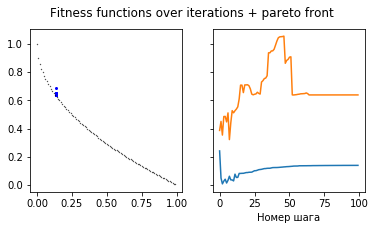

In [57]:
vega = veGA(N = 150, pc = 1.0, pm = 0.001, max_iters = 100)
fitnesses = vega.end_by_steps()

# построим некоторые графики
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
fig.suptitle('Fitness functions over iterations + pareto front')

axs[1].plot(fitnesses[0])
#plt.ylabel("Минимальная оценка критериев")
plt.xlabel("Номер шага");

points = np.array(fitnesses[1])
t = np.arange(0., 1., 0.01)
pselection = (points[:, 0] < 3) * (points[:, 1] < 3)
axs[0].scatter(points[pselection, 0], points[pselection, 1], color = "blue", s = 4)
axs[0].scatter(t, 1 - np.sqrt(t), color = "black", s = 0.1)

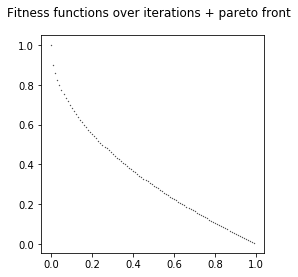

In [6]:
vega = veGA(N = 10, pc = 0.5, pm = 0.001, max_iters = 0)
fitnesses = vega.end_by_steps()

# построим некоторые графики
fig, axs = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
fig.suptitle('Fitness functions over iterations + pareto front')

#axs[1].plot(fitnesses[0])
#plt.ylabel("Минимальная оценка критериев")
#plt.xlabel("Номер шага");

points = np.array(fitnesses[1])
t = np.arange(0., 1., 0.01)
pselection = (points[:, 0] < 3) * (points[:, 1] < 3)
axs.scatter(points[pselection, 0], points[pselection, 1], color = "blue", s = 4)
axs.scatter(t, 1 - np.sqrt(t), color = "black", s = 0.1)